# EDA Effect of Time Elapsed on Gene Expressions

### About the data

Welcome! Here I will be looking at a dataset of gene expressions found in this research paper. https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE5859
This paper looks at the allelic differences among a wide variety of ethnicities across the world. More specifically the data shows the gene expression level found in lympoblasts. Lympoblasts are immature white blood cells that eventually develops into a type of immune cell called lympocyte. If lympoblasts grow and divide uncontrollably, they cause what's known as acute lymphoblastic leukemia. The dataset I will be exploring is a re-formatted version of the one found in the research paper by Harvard CS109, I do not own this dataset.

### Goal

My goal is to detemine if the gene expression of North Americans with Northern and Southern European descent samples' process dates have a large effect on the variability seen in the data

### What I found

After data wrangling, I normalized the gene expression data and used single value decomposition to reduce the dimensionality. I plotted PC1 on the y-axis and elapsed days on the x-axis and discovered that after around 100 days, there was an inconsistency with the data.

## Loading Python modules

In [2]:
%matplotlib inline

import requests
from io import StringIO
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import datetime as dt
import numpy.linalg as lin

## Retrieving data

In [3]:
#retrieving sample info CSV from github
url = "https://raw.githubusercontent.com/cs109/2014_data/master/sampleinfo_GSE5859.csv"
sampleInfo = pd.read_csv(url)
#retrieving gene expression CSV from github
url2 = "https://raw.githubusercontent.com/cs109/2014_data/master/exprs_GSE5859.csv"
exprs = pd.read_csv(url2, index_col=0)
#checking sample info
display(sampleInfo.head())
#checking expression
display(exprs.head())

,ethnicity,date,filename,sex
0,CEU,2003-02-04,GSM25349.CEL.gz,M
1,CEU,2003-02-04,GSM25350.CEL.gz,M
2,CEU,2002-12-17,GSM25356.CEL.gz,M
3,CEU,2003-01-30,GSM25357.CEL.gz,M
4,CEU,2003-01-03,GSM25358.CEL.gz,M


,GSM25581.CEL.gz,GSM25681.CEL.gz,GSM136524.CEL.gz,GSM136707.CEL.gz,GSM25553.CEL.gz,GSM136676.CEL.gz,GSM136711.CEL.gz,GSM136542.CEL.gz,GSM136535.CEL.gz,GSM25399.CEL.gz,...,GSM48650.CEL.gz,GSM25687.CEL.gz,GSM25685.CEL.gz,GSM136549.CEL.gz,GSM25427.CEL.gz,GSM25525.CEL.gz,GSM25349.CEL.gz,GSM136727.CEL.gz,GSM25626.CEL.gz,GSM136725.CEL.gz
1007_s_at,6.333951,5.736190,6.156754,6.513010,6.061013,6.506493,6.863426,6.369645,6.646321,5.810930,...,7.082636,6.315866,7.010165,6.460107,6.122355,6.330314,6.627014,6.133068,6.419444,6.488579
1053_at,7.255622,7.399993,7.491967,7.006123,7.250995,7.082581,6.842236,7.048487,7.042361,6.666625,...,6.599718,7.412731,7.274429,6.928642,7.168782,7.235648,6.939184,7.280781,6.351776,7.517410
117_at,5.760106,4.825169,5.039387,5.414160,5.205697,5.300078,5.099337,5.156459,5.736109,5.807496,...,6.231457,5.240717,5.275062,5.759827,5.409720,5.491938,5.113570,5.401876,5.537605,5.247190
121_at,6.935451,7.025210,7.543667,7.959781,7.223323,8.006816,8.102504,7.434617,7.532321,7.711461,...,8.215096,7.677593,7.923624,7.219401,7.432338,6.785174,7.833862,7.607461,7.302935,7.331864
1255_g_at,3.597872,3.108801,3.128269,3.364947,3.125909,3.186834,3.311022,3.092042,3.167737,2.969579,...,3.331424,3.043856,3.151900,3.132253,3.250600,2.984125,3.152269,3.225123,3.222731,3.175846


## Data Exploration

First I would like to match the order of the sampleInfo filename and the exprs column names

In [4]:
#checking if the order matches
(exprs.columns == sampleInfo.filename).all()
#the order of the filenames in exprs does not match the order of sample info

False

In [5]:
exprs = exprs[sampleInfo.filename]
(exprs.columns == sampleInfo.filename).all()

True

In [6]:
#showing two tables
display(exprs.head())
display(sampleInfo.head())

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM136719.CEL.gz,GSM136720.CEL.gz,GSM136721.CEL.gz,GSM136722.CEL.gz,GSM136723.CEL.gz,GSM136724.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz,GSM136729.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.466445,6.533592,6.631492,6.513362,6.440706,6.704324,6.488579,6.809481,6.133068,6.155473
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.032885,7.156344,7.018025,6.973322,6.884738,7.120898,7.517410,7.200596,7.280781,7.111583
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.661112,5.127260,5.151840,5.505602,5.687689,4.942651,5.247190,5.237239,5.401876,5.302628
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.769734,7.815864,7.683279,7.883231,7.913621,7.834196,7.331864,7.357102,7.607461,7.456453
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.257484,3.339234,3.298384,3.150654,3.344501,3.230285,3.175846,3.105092,3.225123,3.090149


,ethnicity,date,filename,sex
0,CEU,2003-02-04,GSM25349.CEL.gz,M
1,CEU,2003-02-04,GSM25350.CEL.gz,M
2,CEU,2002-12-17,GSM25356.CEL.gz,M
3,CEU,2003-01-30,GSM25357.CEL.gz,M
4,CEU,2003-01-03,GSM25358.CEL.gz,M


I want to see the number of elapsed days from October 31 2002

In [7]:
date = sampleInfo["date"]
dti = pd.to_datetime(date)
df = pd.DataFrame()
df= '2002-10-31'
dti2 = pd.to_datetime(df)
daysSince = dti - dti2
daysSince
sampleInfo.insert(2,"Elapsed Days",daysSince,False)

In [8]:
sampleInfo

,ethnicity,date,Elapsed Days,filename,sex
0,CEU,2003-02-04,96 days,GSM25349.CEL.gz,M
1,CEU,2003-02-04,96 days,GSM25350.CEL.gz,M
2,CEU,2002-12-17,47 days,GSM25356.CEL.gz,M
3,CEU,2003-01-30,91 days,GSM25357.CEL.gz,M
4,CEU,2003-01-03,64 days,GSM25358.CEL.gz,M
...,...,...,...,...,...
203,HAN,2006-04-28,1275 days,GSM136724.CEL.gz,M
204,CEU,2005-02-16,839 days,GSM136725.CEL.gz,F
205,CEU,2005-02-16,839 days,GSM136726.CEL.gz,M
206,CEU,2005-06-10,953 days,GSM136727.CEL.gz,M


I want to exclusively look at ethnicity "CEU" because that represents North Americans of Northern and Southern European descent

In [9]:
sampleinfoCEU = sampleInfo.copy()
sampleinfoCEU = sampleinfoCEU[sampleInfo["ethnicity"] == "CEU"]
sampleinfoCEU

,ethnicity,date,Elapsed Days,filename,sex
0,CEU,2003-02-04,96 days,GSM25349.CEL.gz,M
1,CEU,2003-02-04,96 days,GSM25350.CEL.gz,M
2,CEU,2002-12-17,47 days,GSM25356.CEL.gz,M
3,CEU,2003-01-30,91 days,GSM25357.CEL.gz,M
4,CEU,2003-01-03,64 days,GSM25358.CEL.gz,M
...,...,...,...,...,...
97,CEU,2002-11-22,22 days,GSM48664.CEL.gz,M
98,CEU,2002-11-22,22 days,GSM48665.CEL.gz,F
204,CEU,2005-02-16,839 days,GSM136725.CEL.gz,F
205,CEU,2005-02-16,839 days,GSM136726.CEL.gz,M


Now I must re-match the columns again because I filtered out other ethnicities

In [10]:
exprsCEU = exprs.copy()
exprsCEU = exprsCEU[sampleinfoCEU["filename"]]
display(exprsCEU.head())
exprsCEU.info()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,6.627014,6.249807,5.934128,6.145268,6.091270,6.041186,6.050375,6.063847,6.226106,6.358282,...,6.501510,6.558100,6.618286,6.869995,5.981000,6.403285,6.248702,6.488579,6.809481,6.133068
1053_at,6.939184,6.818038,7.047962,7.422477,7.272361,7.128216,6.750719,6.836287,6.738022,7.367895,...,7.066686,7.386702,6.407958,7.089180,7.120923,7.018998,7.155419,7.517410,7.200596,7.280781
117_at,5.113570,5.074096,5.371201,5.266550,5.342047,5.063876,5.315898,5.483652,6.689444,6.482782,...,5.600514,5.232676,5.630720,4.944748,5.275577,5.770358,5.616842,5.247190,5.237239,5.401876
121_at,7.833862,7.780682,7.458197,7.655948,7.546555,7.072670,7.092984,6.954225,7.489785,7.388539,...,7.437535,7.714650,7.416252,7.746448,8.001434,7.626723,7.452299,7.331864,7.357102,7.607461
1255_g_at,3.152269,3.111747,3.018932,3.154545,3.107954,3.224284,3.114241,3.044975,3.304038,2.887919,...,3.009983,3.151203,3.199709,3.159496,3.149710,3.242780,3.433125,3.175846,3.105092,3.225123


<class 'pandas.core.frame.DataFrame'>
Index: 8793 entries, 1007_s_at to AFFX-r2-P1-cre-5_at
Columns: 102 entries, GSM25349.CEL.gz to GSM136727.CEL.gz
dtypes: float64(102)
memory usage: 6.9+ MB


In [11]:
(exprsCEU.columns == sampleinfoCEU.filename).all()
#matching

True

Now I want to normalize the gene expression data

In [12]:
exprsCEUMean = exprsCEU.copy()
exprsCEUMean = exprsCEUMean.mean(axis = 1)
exprsCEUMean.head()

1007_s_at    6.261955
1053_at      7.075217
117_at       5.604127
121_at       7.415835
1255_g_at    3.133934
dtype: float64

In [13]:
exprsNormal = exprsCEU.copy()
exprsNormal = exprsNormal.sub(exprsCEUMean, axis='index')
exprsNormal.head()

,GSM25349.CEL.gz,GSM25350.CEL.gz,GSM25356.CEL.gz,GSM25357.CEL.gz,GSM25358.CEL.gz,GSM25359.CEL.gz,GSM25360.CEL.gz,GSM25361.CEL.gz,GSM25377.CEL.gz,GSM25378.CEL.gz,...,GSM48658.CEL.gz,GSM48660.CEL.gz,GSM48661.CEL.gz,GSM48662.CEL.gz,GSM48663.CEL.gz,GSM48664.CEL.gz,GSM48665.CEL.gz,GSM136725.CEL.gz,GSM136726.CEL.gz,GSM136727.CEL.gz
1007_s_at,0.365059,-0.012149,-0.327827,-0.116687,-0.170685,-0.220769,-0.211580,-0.198109,-0.035849,0.096327,...,0.239554,0.296144,0.356331,0.608040,-0.280956,0.141330,-0.013254,0.226624,0.547526,-0.128887
1053_at,-0.136032,-0.257178,-0.027254,0.347260,0.197144,0.053000,-0.324497,-0.238930,-0.337195,0.292678,...,-0.008531,0.311485,-0.667259,0.013964,0.045706,-0.056219,0.080203,0.442193,0.125379,0.205564
117_at,-0.490556,-0.530031,-0.232926,-0.337577,-0.262080,-0.540250,-0.288228,-0.120475,1.085317,0.878655,...,-0.003613,-0.371451,0.026594,-0.659379,-0.328549,0.166231,0.012716,-0.356936,-0.366887,-0.202251
121_at,0.418026,0.364847,0.042362,0.240113,0.130720,-0.343165,-0.322852,-0.461611,0.073949,-0.027296,...,0.021700,0.298814,0.000417,0.330612,0.585598,0.210887,0.036463,-0.083972,-0.058733,0.191626
1255_g_at,0.018335,-0.022187,-0.115002,0.020611,-0.025980,0.090351,-0.019693,-0.088959,0.170104,-0.246015,...,-0.123951,0.017269,0.065775,0.025562,0.015776,0.108846,0.299192,0.041912,-0.028842,0.091189


Performing SVD to find PC1

In [14]:
u, s, vh = np.linalg.svd(exprsNormal.values, full_matrices=False)
u.shape, s.shape, vh.shape, vh.T.shape

((8793, 102), (102,), (102, 102), (102, 102))

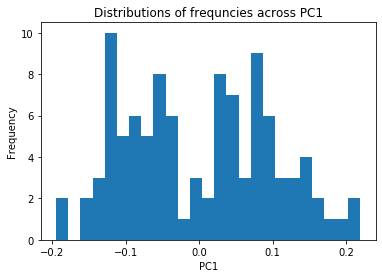

In [20]:
plt.hist(vh.T[:,0],bins=25)
plt.xlabel("PC1")
plt.ylabel("Frequency")
plt.title("Distributions of frequncies across PC1");

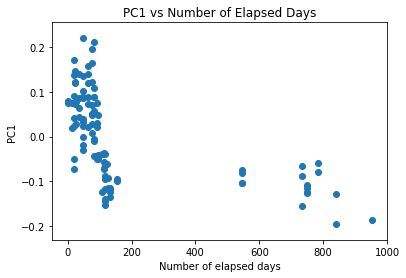

In [19]:
x=sampleinfoCEU['Elapsed Days'].dt.days
y=vh.T[:,0]
plt.scatter(x,y)
plt.ylabel("PC1")
plt.xlabel("Number of elapsed days")
plt.title("PC1 vs Number of Elapsed Days");

# Conclusion

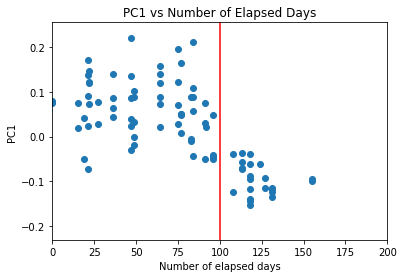

In [24]:
x=sampleinfoCEU['Elapsed Days'].dt.days
y=vh.T[:,0]
plt.scatter(x,y)
plt.xlim(0,200)
plt.ylabel("PC1")
plt.axvline(x=100, color='r')
plt.xlabel("Number of elapsed days")
plt.title("PC1 vs Number of Elapsed Days");

As we can see in the scatter plot above, there was a difference in PC1 after 100 days.